In [1]:
import sys
from pathlib import Path

# Add project root to path
project_root = Path().absolute().parent
sys.path.insert(0, str(project_root))

# Particle Filter Experiments: Spatial Network Linear-Gaussian (SNLG)

This notebook reproduces particle filter results using the Large Spatial Sensor Network (LSSN) simulator with linear-Gaussian dynamics.

**Model:**
- State dynamics: $x_t = \alpha x_{t-1} + v_t$, where $v_t \sim \mathcal{N}(0, \Sigma)$
- Observations: $z_t = x_t + w_t$, where $w_t \sim \mathcal{N}(0, \sigma_z^2 I)$
- Spatial covariance: Squared-exponential (RBF) kernel on n×n grid

In [4]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import json
from dataclasses import asdict
import sys
sys.path.insert(0, str(project_root))

# Import the LSSN simulator
from simulator.simulator_sensor_network_linear_gaussian import (
    SimConfig,
    simulate_dataset,
    save_npz,
    dump_config_json
)

print("✓ Imported LSSN simulator from simulator_sensor_network_linear_gaussian.py")

✓ Imported LSSN simulator from simulator_sensor_network_linear_gaussian.py


In [5]:
# Configure the simulation
config = SimConfig(
    d=64,           # 8×8 spatial grid (64 sensors)
    alpha=0.9,      # Dynamics coefficient
    alpha0=3.0,     # Kernel amplitude
    alpha1=0.01,    # Nugget for numerical stability
    beta=20.0,      # Kernel lengthscale parameter
    T=50,           # Time horizon (50 transitions)
    trials=100,     # Number of independent trials (NEW: 100 trials for experiments)
    sigmas=(2.0, 1.0, 0.5),  # Three observation noise levels
    seed=123        # Random seed for reproducibility
)

print("Simulation Configuration:")
print(f"  State dimension (d): {config.d} (grid size: {int(np.sqrt(config.d))}×{int(np.sqrt(config.d))})")
print(f"  Time horizon (T): {config.T}")
print(f"  Number of trials: {config.trials}")
print(f"  Observation noise levels (σ_z): {config.sigmas}")
print(f"  Dynamics coefficient (α): {config.alpha}")
print(f"  Kernel parameters: α₀={config.alpha0}, α₁={config.alpha1}, β={config.beta}")

Simulation Configuration:
  State dimension (d): 64 (grid size: 8×8)
  Time horizon (T): 50
  Number of trials: 100
  Observation noise levels (σ_z): (2.0, 1.0, 0.5)
  Dynamics coefficient (α): 0.9
  Kernel parameters: α₀=3.0, α₁=0.01, β=20.0


In [6]:
# Generate the simulation data
print("\nGenerating simulation data...")
X, Z, coords, Sigma = simulate_dataset(config)

# Display shapes and basic statistics
print(f"\n✓ Simulation complete!")
print(f"\nData shapes:")
print(f"  X (states):       {X.shape}  → (n_sigmas, n_trials, T+1, d)")
print(f"  Z (observations): {Z.shape}  → (n_sigmas, n_trials, T, d)")
print(f"  coords:           {coords.shape}  → (d, 2)")
print(f"  Sigma (cov):      {Sigma.shape}  → (d, d)")

print(f"\nState statistics (first trial, σ_z={config.sigmas[0]}):")
print(f"  Initial state x₀: mean={X[0, 0, 0].mean():.4f}, std={X[0, 0, 0].std():.4f}")
print(f"  Final state x_T:  mean={X[0, 0, -1].mean():.4f}, std={X[0, 0, -1].std():.4f}")

print(f"\nProcess covariance Σ:")
print(f"  Diagonal (expected ≈{config.alpha0 + config.alpha1:.4f}): {Sigma[0, 0]:.4f}")
print(f"  Min eigenvalue: {np.linalg.eigvalsh(Sigma).min():.6f} (should be > 0)")
print(f"  Max eigenvalue: {np.linalg.eigvalsh(Sigma).max():.4f}")


Generating simulation data...

✓ Simulation complete!

Data shapes:
  X (states):       (3, 100, 51, 64)  → (n_sigmas, n_trials, T+1, d)
  Z (observations): (3, 100, 50, 64)  → (n_sigmas, n_trials, T, d)
  coords:           (64, 2)  → (d, 2)
  Sigma (cov):      (64, 64)  → (d, d)

State statistics (first trial, σ_z=2.0):
  Initial state x₀: mean=0.0000, std=0.0000
  Final state x_T:  mean=0.8974, std=3.4804

Process covariance Σ:
  Diagonal (expected ≈3.0100): 3.0100
  Min eigenvalue: 0.010000 (should be > 0)
  Max eigenvalue: 92.6945


In [7]:
# Save the simulation data
data_dir = project_root / "simulator" / "data"
data_dir.mkdir(exist_ok=True)

output_path = data_dir / "lssn_snlg_dataset.npz"
config_path = data_dir / "lssn_snlg_config.json"

# Save arrays
save_npz(str(output_path), X, Z, coords, Sigma, config)

# Save configuration
dump_config_json(str(config_path), config)

print(f"✓ Data saved to: {output_path}")
print(f"✓ Config saved to: {config_path}")

✓ Data saved to: /Users/amber_test/Desktop/filter/simulator/data/lssn_snlg_dataset.npz
✓ Config saved to: /Users/amber_test/Desktop/filter/simulator/data/lssn_snlg_config.json


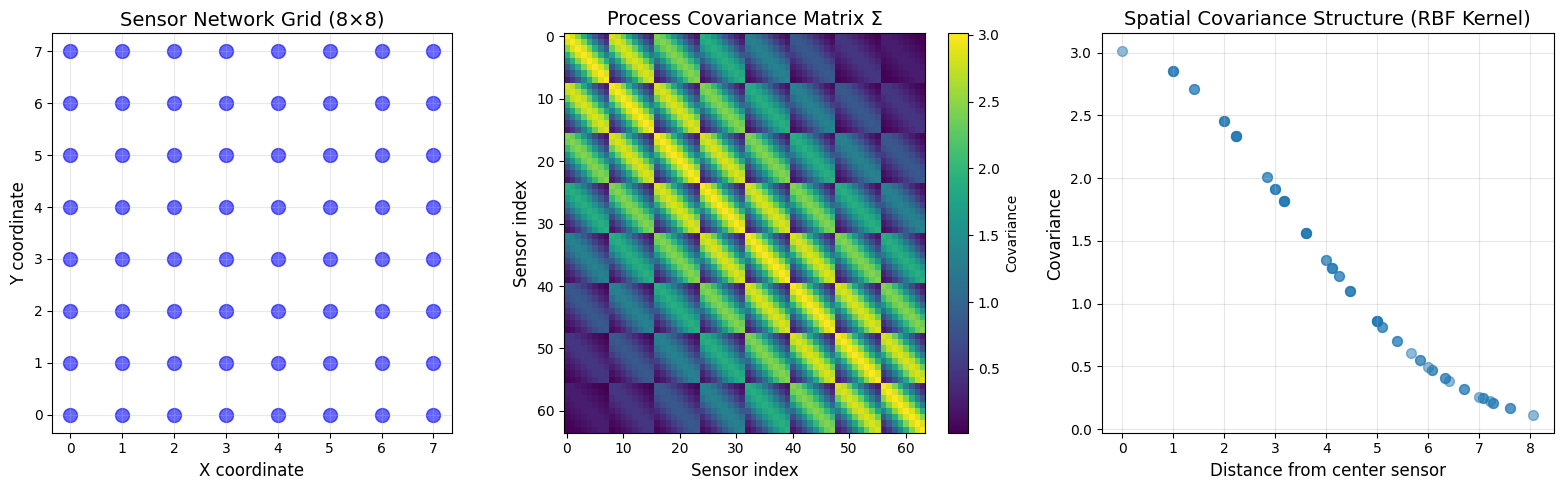

Grid structure: 8×8 = 64 sensors
Covariance range: [0.0223, 3.0100]


In [9]:
# Visualize the spatial grid and covariance structure
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 1. Spatial grid layout
ax = axes[0]
ax.scatter(coords[:, 0], coords[:, 1], s=100, alpha=0.6, c='blue')
ax.set_xlabel('X coordinate', fontsize=12)
ax.set_ylabel('Y coordinate', fontsize=12)
ax.set_title(f'Sensor Network Grid ({int(np.sqrt(config.d))}×{int(np.sqrt(config.d))})', fontsize=14)
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')

# 2. Process covariance matrix
ax = axes[1]
im = ax.imshow(Sigma, cmap='viridis', aspect='auto')
ax.set_xlabel('Sensor index', fontsize=12)
ax.set_ylabel('Sensor index', fontsize=12)
ax.set_title('Process Covariance Matrix Σ', fontsize=14)
plt.colorbar(im, ax=ax, label='Covariance')

# 3. Covariance vs distance (from center sensor)
ax = axes[2]
center_idx = config.d // 2
center_coord = coords[center_idx]
distances = np.sqrt(np.sum((coords - center_coord)**2, axis=1))
covs = Sigma[center_idx, :]

ax.scatter(distances, covs, alpha=0.5, s=50)
ax.set_xlabel('Distance from center sensor', fontsize=12)
ax.set_ylabel('Covariance', fontsize=12)
ax.set_title('Spatial Covariance Structure (RBF Kernel)', fontsize=14)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Grid structure: {int(np.sqrt(config.d))}×{int(np.sqrt(config.d))} = {config.d} sensors")
print(f"Covariance range: [{Sigma.min():.4f}, {Sigma.max():.4f}]")

Run Filter Experiments

Now we'll run multiple filters on the simulation data and compare their performance:
- **LEDH**: 200 particles
- **EDH**: 200 and 10,000 particles  
- **KF**: Kalman Filter (optimal for linear-Gaussian)
- **UKF**: Unscented Kalman Filter

**Metrics tracked:**
- Average MSE (Mean Squared Error)
- Average ESS (Effective Sample Size) for particle filters
- Execution time

In [10]:
# Import filter implementations
from models.kalman_filter import kalman_filter_general
from models.unscented_kalman_filter import UnscentedKalmanFilter
from models.extended_kalman_filter import ExtendedKalmanFilter, EKFState
from models.EDH_particle_filter import EDHFlowPF, EDHConfig, EKFTracker, PFState
from models.LEDH_particle_filter import LEDHFlowPF, LEDHConfig
from models.LEDH_particle_filter import PFState as LEDHPFState

import time

print("✓ Imported filter implementations")

✓ Imported filter implementations


In [11]:
# Helper functions for running experiments
from models.unscented_kalman_filter import UKFState

def compute_mse(x_true, x_est):
    """Compute Mean Squared Error between true and estimated states."""
    return np.mean((x_true - x_est) ** 2)

def run_kf_experiment(X_true, Z_obs, Sigma, alpha, sigma_z):
    """Run Kalman Filter on one trial."""
    T, d = Z_obs.shape
    
    # Prepare matrices for kalman_filter_general
    # State transition: x_k = alpha * x_{k-1} + Gamma * w_k
    Phi = alpha * np.eye(d)
    H_mat = np.eye(d) 
    Gamma = np.eye(d)
    Q = Sigma.copy()
    R = (sigma_z ** 2) * np.eye(d)
    
    # Initial conditions
    x0 = np.zeros(d)
    P0 = Sigma.copy()
    
    # Run filter
    start_time = time.time()
    results = kalman_filter_general(
        Y=Z_obs, 
        Phi=Phi, 
        H=H_mat, 
        Gamma=Gamma, 
        Q=Q, 
        R=R,
        x0=x0, 
        P0=P0
    )
    elapsed = time.time() - start_time
    
    # Get filtered estimates (skip x0)
    x_est = results.x_filt  # Shape: (T, d)
    
    # Compute MSE (compare X_true[1:] with x_est)
    mse = compute_mse(X_true[1:], x_est)
    
    return mse, elapsed

def run_ukf_experiment(X_true, Z_obs, Sigma, alpha, sigma_z):
    """Run Unscented Kalman Filter on one trial."""
    T, d = Z_obs.shape
    
    # Initialize UKF
    Q = Sigma.copy()
    R = (sigma_z ** 2) * np.eye(d)
    
    # Define dynamics and observation functions
    def f(x, u):
        return alpha * x
    
    def h(x):
        return x
    
    ukf = UnscentedKalmanFilter(f, h, Q, R)
    
    # Initial state
    x0 = np.zeros(d)
    P0 = Sigma.copy()
    state = UKFState(mean=x0, cov=P0, t=0)
    
    # Run filter
    x_est = []
    start_time = time.time()
    for t in range(T):
        state = ukf.predict(state)
        state = ukf.update(state, Z_obs[t])
        x_est.append(state.mean.copy())
    elapsed = time.time() - start_time
    
    x_est = np.array(x_est)  # Shape: (T, d)
    
    # Compute MSE
    mse = compute_mse(X_true[1:], x_est)
    
    return mse, elapsed

# Helper function for particle filters
def run_edh_experiment(X_true, Z_obs, Sigma, alpha, sigma_z, N_particles, seed):
    """Run EDH Particle Filter with EKF tracker on one trial."""
    T, d = Z_obs.shape
    
    Q = Sigma.copy()
    R = (sigma_z ** 2) * np.eye(d)
    
    # Define model functions for EKF (no noise arguments)
    def g_ekf(x, u):
        return alpha * x
    
    def h_ekf(x):
        return x
    
    def jac_g(x, u):
        return alpha * np.eye(d)
    
    def jac_h(x):
        return np.eye(d)
    
    # Define model functions for EDH (with noise arguments)
    def g_edh(x, u, v):
        if v is None:
            v = np.zeros_like(x)
        return alpha * x + v
    
    def h_edh(x):
        return x
    
    # Log densities
    def log_trans_pdf(xk, xkm1):
        diff = xk - alpha * xkm1
        return -0.5 * (diff.T @ np.linalg.solve(Q, diff) + d * np.log(2 * np.pi) + np.linalg.slogdet(Q)[1])
    
    def log_like_pdf(z, x):
        diff = z - h_edh(x)
        return -0.5 * (diff.T @ np.linalg.solve(R, diff) + d * np.log(2 * np.pi) + np.linalg.slogdet(R)[1])
    
    # Initialize EKF tracker
    ekf = ExtendedKalmanFilter(g=g_ekf, h=h_ekf, jac_g=jac_g, jac_h=jac_h, Q=Q, R=R)
    ekf_state = EKFState(mean=np.zeros(d), cov=Sigma.copy(), t=0)
    tracker = EKFTracker(ekf, ekf_state)
    
    # Initialize EDH-PF
    cfg = EDHConfig(
        n_particles=N_particles,
        n_lambda_steps=4,
        resample_ess_ratio=0.5,
        rng=np.random.default_rng(seed)
    )
    
    edh_pf = EDHFlowPF(
        tracker=tracker,
        g=g_edh,
        h=h_edh,
        jacobian_h=jac_h,
        log_trans_pdf=log_trans_pdf,
        log_like_pdf=log_like_pdf,
        R=R,
        config=cfg
    )
    
    # Initialize particles
    x0 = np.zeros(d)
    P0 = Sigma.copy()
    state = edh_pf.init_from_gaussian(x0, P0)
    
    # Run filter
    x_est = [x0]
    ess_values = []
    
    def process_noise_sampler(N, nx):
        return cfg.rng.multivariate_normal(np.zeros(nx), Q, size=N)
    
    start_time = time.time()
    for t in range(T):
        state = edh_pf.step(state, Z_obs[t], process_noise_sampler=process_noise_sampler)
        x_est.append(state.mean.copy())
        # Compute ESS from weights
        ess = 1.0 / np.sum(state.weights ** 2)
        ess_values.append(ess)
    elapsed = time.time() - start_time
    
    x_est = np.array(x_est[1:])  # Shape: (T, d) - skip x0
    
    # Compute MSE
    mse = compute_mse(X_true[1:], x_est)
    avg_ess = np.mean(ess_values)
    
    return mse, avg_ess, elapsed

def run_ledh_experiment(X_true, Z_obs, Sigma, alpha, sigma_z, N_particles, seed):
    """Run LEDH Particle Filter with EKF tracker on one trial."""
    T, d = Z_obs.shape
    
    Q = Sigma.copy()
    R = (sigma_z ** 2) * np.eye(d)
    
    # Define model functions for EKF
    def g_ekf(x, u):
        return alpha * x
    
    def h_ekf(x):
        return x
    
    def jac_g(x, u):
        return alpha * np.eye(d)
    
    def jac_h(x):
        return np.eye(d)
    
    # Define model functions for LEDH
    def g_ledh(x, u, v):
        if v is None:
            v = np.zeros_like(x)
        return alpha * x + v
    
    def h_ledh(x):
        return x
    
    # Log densities
    def log_trans_pdf(xk, xkm1):
        diff = xk - alpha * xkm1
        return -0.5 * (diff.T @ np.linalg.solve(Q, diff) + d * np.log(2 * np.pi) + np.linalg.slogdet(Q)[1])
    
    def log_like_pdf(z, x):
        diff = z - h_ledh(x)
        return -0.5 * (diff.T @ np.linalg.solve(R, diff) + d * np.log(2 * np.pi) + np.linalg.slogdet(R)[1])
    
    # Initialize EKF tracker
    ekf = ExtendedKalmanFilter(g=g_ekf, h=h_ekf, jac_g=jac_g, jac_h=jac_h, Q=Q, R=R)
    ekf_state = EKFState(mean=np.zeros(d), cov=Sigma.copy(), t=0)
    tracker = EKFTracker(ekf, ekf_state)
    
    # Initialize LEDH-PF
    cfg = LEDHConfig(
        n_particles=N_particles,
        n_lambda_steps=4,
        resample_ess_ratio=0.5,
        rng=np.random.default_rng(seed)
    )
    
    ledh_pf = LEDHFlowPF(
        tracker=tracker,
        g=g_ledh,
        h=h_ledh,
        jacobian_h=jac_h,
        log_trans_pdf=log_trans_pdf,
        log_like_pdf=log_like_pdf,
        R=R,
        config=cfg
    )
    
    # Initialize particles
    x0 = np.zeros(d)
    P0 = Sigma.copy()
    state = ledh_pf.init_from_gaussian(x0, P0)
    
    # Run filter
    x_est = [x0]
    ess_values = []
    
    def process_noise_sampler(N, nx):
        return cfg.rng.multivariate_normal(np.zeros(nx), Q, size=N)
    
    start_time = time.time()
    for t in range(T):
        state = ledh_pf.step(state, Z_obs[t], process_noise_sampler=process_noise_sampler)
        x_est.append(state.mean.copy())
        # Compute ESS from weights
        ess = 1.0 / np.sum(state.weights ** 2)
        ess_values.append(ess)
    elapsed = time.time() - start_time
    
    x_est = np.array(x_est[1:])  # Shape: (T, d) - skip x0
    
    # Compute MSE
    mse = compute_mse(X_true[1:], x_est)
    avg_ess = np.mean(ess_values)
    
    return mse, avg_ess, elapsed

print("✓ Helper functions defined")

✓ Helper functions defined


In [12]:
# Configure experiments - USE FRESHLY GENERATED 100-TRIAL DATA
NUM_TRIALS = config.trials  # Use the 100 trials from freshly generated data
SIGMA_Z_VALUES = list(config.sigmas)  # [2.0, 1.0, 0.5]

# Filter configurations 
filter_configs = {
    'KF': {'type': 'kf'},
    'UKF': {'type': 'ukf'},
    'LEDH-200': {'type': 'ledh', 'N': 200},
    'EDH-200': {'type': 'edh', 'N': 200},
    'EDH-10000': {'type': 'edh', 'N': 10000},
}

print(f"Experiment Configuration:")
print(f"  Number of trials: {NUM_TRIALS} (using freshly generated data)")
print(f"  Observation noise levels: {SIGMA_Z_VALUES}")
print(f"  Filters: {list(filter_configs.keys())}")
print(f"  State dimension: d = {config.d}")
print(f"  Dynamics: α = {config.alpha}")

Experiment Configuration:
  Number of trials: 100 (using freshly generated data)
  Observation noise levels: [2.0, 1.0, 0.5]
  Filters: ['KF', 'UKF', 'LEDH-200', 'EDH-200', 'EDH-10000']
  State dimension: d = 64
  Dynamics: α = 0.9


In [13]:
# Run experiments  
results = {
    filter_name: {
        sigma_z: {'mse': [], 'ess': [],'time': []}
        for sigma_z in SIGMA_Z_VALUES
    }
    for filter_name in filter_configs.keys()
}

print("Running experiments...")
print("=" * 80)

for sigma_idx, sigma_z in enumerate(SIGMA_Z_VALUES):
    print(f"\n📊 Observation noise σ_z = {sigma_z}")
    print("-" * 80)
    
    for filter_name, config_dict in filter_configs.items():
        print(f"\n  🔹 Running {filter_name}...", end=" ", flush=True)
        
        for trial in range(NUM_TRIALS):
            # Get trial data from FRESHLY GENERATED data (X, Z from cell 6)
            X_true = X[sigma_idx, trial]  # Shape: (T+1, d)
            Z_obs = Z[sigma_idx, trial]   # Shape: (T, d)
            
            # Run filter based on type
            if config_dict['type'] == 'kf':
                mse, elapsed = run_kf_experiment(
                    X_true, Z_obs, Sigma, config.alpha, sigma_z
                )
                ess = None  # KF doesn't have ESS
                
            elif config_dict['type'] == 'ukf':
                mse, elapsed = run_ukf_experiment(
                    X_true, Z_obs, Sigma, config.alpha, sigma_z
                )
                ess = None  # UKF doesn't have ESS

            elif config_dict['type'] == 'ledh':
                trial_seed = 1000 + trial
                mse, ess, elapsed = run_ledh_experiment(
                    X_true, Z_obs, Sigma, config.alpha, sigma_z,
                    config_dict['N'], trial_seed
                )
                
            elif config_dict['type'] == 'edh':
                trial_seed = 1000 + trial
                mse, ess, elapsed = run_edh_experiment(
                    X_true, Z_obs, Sigma, config.alpha, sigma_z,
                    config_dict['N'], trial_seed
                )
            
            # Store results
            results[filter_name][sigma_z]['mse'].append(mse)
            if ess is not None:
                results[filter_name][sigma_z]['ess'].append(ess)
            results[filter_name][sigma_z]['time'].append(elapsed)
        
        # Compute averages
        avg_mse = np.mean(results[filter_name][sigma_z]['mse'])
        avg_time = np.mean(results[filter_name][sigma_z]['time'])
        if len(results[filter_name][sigma_z]['ess']) > 0:
            avg_ess = np.mean(results[filter_name][sigma_z]['ess'])
            print(f"  ✓ Averages: MSE={avg_mse:.4f}, ESS={avg_ess:.1f}, Time={avg_time:.2f}s")
        else:
            print(f"  ✓ Averages: MSE={avg_mse:.4f}, Time={avg_time:.2f}s")

print("\n" + "=" * 80)
print("✓ Experiments complete!")

Running experiments...

📊 Observation noise σ_z = 2.0
--------------------------------------------------------------------------------

  🔹 Running KF...   ✓ Averages: MSE=0.4958, Time=0.01s

  🔹 Running UKF...   ✓ Averages: MSE=0.4958, Time=0.01s

  🔹 Running UKF...   ✓ Averages: MSE=0.4958, Time=0.22s

  🔹 Running LEDH-200...   ✓ Averages: MSE=0.4958, Time=0.22s

  🔹 Running LEDH-200...   ✓ Averages: MSE=0.6512, ESS=200.0, Time=7.38s

  🔹 Running EDH-200...   ✓ Averages: MSE=0.6512, ESS=200.0, Time=7.38s

  🔹 Running EDH-200...   ✓ Averages: MSE=0.6510, ESS=200.0, Time=1.98s

  🔹 Running EDH-10000...   ✓ Averages: MSE=0.6510, ESS=200.0, Time=1.98s

  🔹 Running EDH-10000...   ✓ Averages: MSE=0.5340, ESS=10000.0, Time=90.90s

📊 Observation noise σ_z = 1.0
--------------------------------------------------------------------------------

  🔹 Running KF...   ✓ Averages: MSE=0.5340, ESS=10000.0, Time=90.90s

📊 Observation noise σ_z = 1.0
----------------------------------------------------

In [14]:
# Aggregate and display results in a structured table
import pandas as pd

# Create results table
table_data = []
for filter_name in filter_configs.keys():
    for sigma_z in SIGMA_Z_VALUES:
        avg_mse = np.mean(results[filter_name][sigma_z]['mse'])
        std_mse = np.std(results[filter_name][sigma_z]['mse'])
        avg_time = np.mean(results[filter_name][sigma_z]['time'])
        std_time = np.std(results[filter_name][sigma_z]['time'])
        
        # Handle ESS (only for particle filters)
        if len(results[filter_name][sigma_z]['ess']) > 0:
            avg_ess = np.mean(results[filter_name][sigma_z]['ess'])
            std_ess = np.std(results[filter_name][sigma_z]['ess'])
            ess_str = f"{avg_ess:.2f}"
            ess_std_str = f"{std_ess:.2f}"
        else:
            ess_str = "N/A"
            ess_std_str = "N/A"
        
        table_data.append({
            'Filter': filter_name,
            'σ_z': sigma_z,
            'Avg MSE': f"{avg_mse:.6f}",
            'Std MSE': f"{std_mse:.6f}",
            'Avg ESS': ess_str,
            'Std ESS': ess_std_str,
            'Avg Time (s)': f"{avg_time:.4f}",
            'Std Time (s)': f"{std_time:.4f}",
        })

results_df = pd.DataFrame(table_data)

print("\n📊 EXPERIMENTAL RESULTS SUMMARY")
print("=" * 100)
print(results_df.to_string(index=False))
print("=" * 100)

# Save results
results_path = data_dir / "filter_comparison_results.csv"
results_df.to_csv(results_path, index=False)
print(f"\n✓ Results saved to: {results_path}")


📊 EXPERIMENTAL RESULTS SUMMARY
   Filter  σ_z  Avg MSE  Std MSE  Avg ESS Std ESS Avg Time (s) Std Time (s)
       KF  2.0 0.495776 0.031657      N/A     N/A       0.0123       0.0038
       KF  1.0 0.191759 0.009388      N/A     N/A       0.0117       0.0036
       KF  0.5 0.073245 0.003045      N/A     N/A       0.0106       0.0031
      UKF  2.0 0.495776 0.031657      N/A     N/A       0.2190       0.0156
      UKF  1.0 0.191759 0.009388      N/A     N/A       0.2195       0.0049
      UKF  0.5 0.073245 0.003045      N/A     N/A       0.2196       0.0040
 LEDH-200  2.0 0.651244 0.045460   200.00    0.00       7.3751       0.2891
 LEDH-200  1.0 0.289939 0.014769   200.00    0.00       7.1587       0.4643
 LEDH-200  0.5 0.141152 0.007061   200.00    0.00       7.1711       0.1850
  EDH-200  2.0 0.650995 0.043538   200.00    0.00       1.9817       0.1093
  EDH-200  1.0 0.328265 0.016427   200.00    0.00       2.0816       0.0770
  EDH-200  0.5 0.189817 0.010861   200.00    0.00       

## Covariance Perturbation Analysis 

Investigate the sensitivity of LEDH and EDH algorithms to errors in the predictive covariance estimate. 
**Method:** 
1. Perturb the KF-estimated covariance $\hat{P}$ to create noisy estimate $\tilde{P}$ 
2. Use eigendecomposition: $\hat{P} = V D V^T$ 
3. Generate perturbed eigenvalues: $\tilde{D} = \xi \circ D$ where $\xi \sim \ln N(0, \sigma_p^2)$ 
4. Reconstruct: $\tilde{P} = V \times \text{diag}(\tilde{D}) \times V^T$ 
5. Test $\sigma_p \in \{0, 0.1, 0.2, 0.5, 1.0\}$

In [17]:
# Function to perturb covariance matrix
def perturb_covariance(P, sigma_p, rng):
    """
    Perturb covariance matrix P by adding noise to eigenvalues.
    
    Args:
        P: Original covariance matrix (d, d)
        sigma_p: Perturbation level (std of log-normal)
        rng: Random number generator
        
    Returns:
        P_tilde: Perturbed covariance matrix (d, d)
    """
    if sigma_p == 0:
        return P.copy()
    
    # Eigendecomposition
    eigenvalues, eigenvectors = np.linalg.eigh(P)  # eigh for symmetric matrices
    
    # Generate log-normal noise: xi ~ LogNormal(0, sigma_p^2)
    # LogNormal(0, sigma_p^2) means ln(xi) ~ N(0, sigma_p^2)
    xi = rng.lognormal(mean=0, sigma=sigma_p, size=len(eigenvalues))
    
    # Perturb eigenvalues (element-wise multiplication)
    D_tilde = xi * eigenvalues
    
    # Reconstruct perturbed covariance
    P_tilde = eigenvectors @ np.diag(D_tilde) @ eigenvectors.T
    
    # Ensure symmetry (numerical stability)
    P_tilde = 0.5 * (P_tilde + P_tilde.T)
    
    return P_tilde

def compute_perturbation_ratio(P_original, P_perturbed):
    """Compute ||P_perturbed - P_original|| / ||P_original||"""
    diff_norm = np.linalg.norm(P_perturbed - P_original, 'fro')
    orig_norm = np.linalg.norm(P_original, 'fro')
    return diff_norm / orig_norm

print("✓ Covariance perturbation function defined")

✓ Covariance perturbation function defined


In [18]:
# Modified particle filter functions with covariance perturbation
def run_edh_with_perturbation(X_true, Z_obs, Sigma, alpha, sigma_z, N_particles, sigma_p, seed):
    """Run EDH with perturbed covariance estimates."""
    T, d = Z_obs.shape
    rng = np.random.default_rng(seed)
    
    Q = Sigma.copy()
    R = (sigma_z ** 2) * np.eye(d)
    
    # Define model functions
    def g_ekf(x, u):
        return alpha * x
    
    def h_ekf(x):
        return x
    
    def jac_g(x, u):
        return alpha * np.eye(d)
    
    def jac_h(x):
        return np.eye(d)
    
    def g_edh(x, u, v):
        if v is None:
            v = np.zeros_like(x)
        return alpha * x + v
    
    def h_edh(x):
        return x
    
    def log_trans_pdf(xk, xkm1):
        diff = xk - alpha * xkm1
        return -0.5 * (diff.T @ np.linalg.solve(Q, diff) + d * np.log(2 * np.pi) + np.linalg.slogdet(Q)[1])
    
    def log_like_pdf(z, x):
        diff = z - h_edh(x)
        return -0.5 * (diff.T @ np.linalg.solve(R, diff) + d * np.log(2 * np.pi) + np.linalg.slogdet(R)[1])
    
    # Initialize EKF tracker
    ekf = ExtendedKalmanFilter(g=g_ekf, h=h_ekf, jac_g=jac_g, jac_h=jac_h, Q=Q, R=R)
    ekf_state = EKFState(mean=np.zeros(d), cov=Sigma.copy(), t=0)
    tracker = EKFTracker(ekf, ekf_state)
    
    # Initialize EDH-PF with modified config to access tracker covariance
    cfg = EDHConfig(
        n_particles=N_particles,
        n_lambda_steps=4,
        resample_ess_ratio=0.5,
        rng=rng
    )
    
    edh_pf = EDHFlowPF(
        tracker=tracker,
        g=g_edh,
        h=h_edh,
        jacobian_h=jac_h,
        log_trans_pdf=log_trans_pdf,
        log_like_pdf=log_like_pdf,
        R=R,
        config=cfg
    )
    
    # Initialize particles
    x0 = np.zeros(d)
    P0 = Sigma.copy()
    state = edh_pf.init_from_gaussian(x0, P0)
    
    # Run filter with covariance perturbation
    x_est = [x0]
    ess_values = []
    
    def process_noise_sampler(N, nx):
        return cfg.rng.multivariate_normal(np.zeros(nx), Q, size=N)
    
    start_time = time.time()
    for t in range(T):
        # Before prediction, perturb the tracker's covariance
        if sigma_p > 0:
            # Get current covariance from tracker
            original_cov = edh_pf.tracker.state.cov.copy()
            # Perturb it
            perturbed_cov = perturb_covariance(original_cov, sigma_p, rng)
            # Update tracker with perturbed covariance
            edh_pf.tracker.state = EKFState(
                mean=edh_pf.tracker.state.mean,
                cov=perturbed_cov,
                t=edh_pf.tracker.state.t
            )
        
        state = edh_pf.step(state, Z_obs[t], process_noise_sampler=process_noise_sampler)
        x_est.append(state.mean.copy())
        ess = 1.0 / np.sum(state.weights ** 2)
        ess_values.append(ess)
    elapsed = time.time() - start_time
    
    x_est = np.array(x_est[1:])
    mse = compute_mse(X_true[1:], x_est)
    avg_ess = np.mean(ess_values)
    
    return mse, avg_ess, elapsed

def run_ledh_with_perturbation(X_true, Z_obs, Sigma, alpha, sigma_z, N_particles, sigma_p, seed):
    """Run LEDH with perturbed covariance estimates."""
    T, d = Z_obs.shape
    rng = np.random.default_rng(seed)
    
    Q = Sigma.copy()
    R = (sigma_z ** 2) * np.eye(d)
    
    # Define model functions
    def g_ekf(x, u):
        return alpha * x
    
    def h_ekf(x):
        return x
    
    def jac_g(x, u):
        return alpha * np.eye(d)
    
    def jac_h(x):
        return np.eye(d)
    
    def g_ledh(x, u, v):
        if v is None:
            v = np.zeros_like(x)
        return alpha * x + v
    
    def h_ledh(x):
        return x
    
    def log_trans_pdf(xk, xkm1):
        diff = xk - alpha * xkm1
        return -0.5 * (diff.T @ np.linalg.solve(Q, diff) + d * np.log(2 * np.pi) + np.linalg.slogdet(Q)[1])
    
    def log_like_pdf(z, x):
        diff = z - h_ledh(x)
        return -0.5 * (diff.T @ np.linalg.solve(R, diff) + d * np.log(2 * np.pi) + np.linalg.slogdet(R)[1])
    
    # Initialize EKF tracker
    ekf = ExtendedKalmanFilter(g=g_ekf, h=h_ekf, jac_g=jac_g, jac_h=jac_h, Q=Q, R=R)
    ekf_state = EKFState(mean=np.zeros(d), cov=Sigma.copy(), t=0)
    tracker = EKFTracker(ekf, ekf_state)
    
    # Initialize LEDH-PF
    cfg = LEDHConfig(
        n_particles=N_particles,
        n_lambda_steps=4,
        resample_ess_ratio=0.5,
        rng=rng
    )
    
    ledh_pf = LEDHFlowPF(
        tracker=tracker,
        g=g_ledh,
        h=h_ledh,
        jacobian_h=jac_h,
        log_trans_pdf=log_trans_pdf,
        log_like_pdf=log_like_pdf,
        R=R,
        config=cfg
    )
    
    # Initialize particles
    x0 = np.zeros(d)
    P0 = Sigma.copy()
    state = ledh_pf.init_from_gaussian(x0, P0)
    
    # Run filter with covariance perturbation
    x_est = [x0]
    ess_values = []
    
    def process_noise_sampler(N, nx):
        return cfg.rng.multivariate_normal(np.zeros(nx), Q, size=N)
    
    start_time = time.time()
    for t in range(T):
        # Before prediction, perturb the tracker's covariance
        if sigma_p > 0:
            original_cov = ledh_pf.tracker.state.cov.copy()
            perturbed_cov = perturb_covariance(original_cov, sigma_p, rng)
            ledh_pf.tracker.state = EKFState(
                mean=ledh_pf.tracker.state.mean,
                cov=perturbed_cov,
                t=ledh_pf.tracker.state.t
            )
        
        state = ledh_pf.step(state, Z_obs[t], process_noise_sampler=process_noise_sampler)
        x_est.append(state.mean.copy())
        ess = 1.0 / np.sum(state.weights ** 2)
        ess_values.append(ess)
    elapsed = time.time() - start_time
    
    x_est = np.array(x_est[1:])
    mse = compute_mse(X_true[1:], x_est)
    avg_ess = np.mean(ess_values)
    
    return mse, avg_ess, elapsed

print("✓ Perturbation-aware particle filter functions defined")

✓ Perturbation-aware particle filter functions defined


In [19]:
# Covariance Perturbation Experiment
# Test sigma_p values: [0, 0.1, 0.2, 0.5, 1.0]
# Filters: LEDH(200), EDH(200), EDH(10000)
# Fix sigma_z = 1.0 (middle noise level)

sigma_p_values = [0, 0.1, 0.2, 0.5, 1.0]
filters_config = [
    ('LEDH', 200, run_ledh_with_perturbation),
    ('EDH', 200, run_edh_with_perturbation),
    ('EDH', 10000, run_edh_with_perturbation),
]

# Use sigma_z = 1.0 dataset (middle noise level, index 1)
sigma_z_idx = 1
sigma_z_test = SIGMA_Z_VALUES[sigma_z_idx]

print(f"Running covariance perturbation analysis with σ_z = {sigma_z_test}")
print(f"Testing {len(sigma_p_values)} σ_p values on {config.trials} trials (FRESH DATA)")
print(f"Filters: LEDH(200), EDH(200), EDH(10000)")
print("=" * 70)

perturbation_results = []

for filter_name, n_particles, run_func in filters_config:
    filter_label = f"{filter_name}({n_particles})"
    print(f"\n{filter_label}")
    print("-" * 70)
    
    for sigma_p in sigma_p_values:
        mse_list = []
        ess_list = []
        time_list = []
        
        print(f"  σ_p = {sigma_p:.1f}: ", end="", flush=True)
        
        for trial_idx in range(config.trials):
            # Use FRESHLY GENERATED data (X, Z from cell 6)
            X_true = X[sigma_z_idx, trial_idx]  # (T+1, d)
            Z_obs = Z[sigma_z_idx, trial_idx]   # (T, d)
            
            seed = 5000 + trial_idx + int(sigma_p * 1000)
            
            try:
                mse, avg_ess, elapsed = run_func(
                    X_true, Z_obs, Sigma, config.alpha, sigma_z_test, 
                    n_particles, sigma_p, seed
                )
                
                mse_list.append(mse)
                ess_list.append(avg_ess)
                time_list.append(elapsed)
                
                if (trial_idx + 1) % 2 == 0:
                    print(".", end="", flush=True)
            
            except Exception as e:
                print(f"\n    Error in trial {trial_idx}: {e}")
                continue
        
        avg_mse = np.mean(mse_list)
        avg_ess = np.mean(ess_list)
        avg_time = np.mean(time_list)
        
        print(f" MSE={avg_mse:.4f}, ESS={avg_ess:.1f}, Time={avg_time:.2f}s")
        
        perturbation_results.append({
            'Filter': filter_label,
            'N_particles': n_particles,
            'sigma_p': sigma_p,
            'avg_mse': avg_mse,
            'avg_ess': avg_ess,
            'avg_time': avg_time,
            'trials': len(mse_list)
        })

df_perturbation = pd.DataFrame(perturbation_results)
print("\n" + "=" * 70)
print("Covariance perturbation analysis complete!")
print(f"Total experiments: {len(perturbation_results)}")

Running covariance perturbation analysis with σ_z = 1.0
Testing 5 σ_p values on 100 trials (FRESH DATA)
Filters: LEDH(200), EDH(200), EDH(10000)

LEDH(200)
----------------------------------------------------------------------
  σ_p = 0.0: ................................................................................................... MSE=0.2884, ESS=200.0, Time=8.59s
  σ_p = 0.1: . MSE=0.2884, ESS=200.0, Time=8.59s
  σ_p = 0.1: ................................................................................................... MSE=0.2876, ESS=200.0, Time=8.66s
  σ_p = 0.2: . MSE=0.2876, ESS=200.0, Time=8.66s
  σ_p = 0.2: ................................................................................................... MSE=0.2912, ESS=200.0, Time=8.93s
  σ_p = 0.5: . MSE=0.2912, ESS=200.0, Time=8.93s
  σ_p = 0.5: ................................................................................................... MSE=0.3119, ESS=200.0, Time=8.91s
  σ_p = 1.0: . MSE=0.3119, ESS=200.0, 

In [20]:
# Display results organized by filter
print("Covariance Perturbation Results (σ_z = 1.0)")
print("=" * 80)

for filter_label in ['LEDH(200)', 'EDH(200)', 'EDH(10000)']:
    df_filter = df_perturbation[df_perturbation['Filter'] == filter_label]
    print(f"\n{filter_label}:")
    print(df_filter[['sigma_p', 'avg_mse', 'avg_ess', 'avg_time']].to_string(index=False))

# Summary table
print("\n" + "=" * 80)
print("Summary Table (Average MSE and ESS)")
print("=" * 80)
pivot_mse = df_perturbation.pivot(index='sigma_p', columns='Filter', values='avg_mse')
pivot_ess = df_perturbation.pivot(index='sigma_p', columns='Filter', values='avg_ess')

print("\nAverage MSE:")
print(pivot_mse.to_string())
print("\nAverage ESS:")
print(pivot_ess.to_string())

df_perturbation

Covariance Perturbation Results (σ_z = 1.0)

LEDH(200):
 sigma_p  avg_mse  avg_ess  avg_time
     0.0 0.288438    200.0  8.589723
     0.1 0.287621    200.0  8.661304
     0.2 0.291219    200.0  8.932986
     0.5 0.311948    200.0  8.906728
     1.0 0.366191    200.0  7.682714

EDH(200):
 sigma_p  avg_mse  avg_ess  avg_time
     0.0 0.327287    200.0  1.943288
     0.1 0.328896    200.0  1.997225
     0.2 0.333154    200.0  1.791223
     0.5 0.362490    200.0  1.742982
     1.0 0.441036    200.0  1.762168

EDH(10000):
 sigma_p  avg_mse  avg_ess   avg_time
     0.0 0.249974  10000.0 116.368549
     0.1 0.252918  10000.0  90.432375
     0.2 0.257078  10000.0  86.529693
     0.5 0.287149  10000.0 105.063469
     1.0 0.373057  10000.0  92.740362

Summary Table (Average MSE and ESS)

Average MSE:
Filter   EDH(10000)  EDH(200)  LEDH(200)
sigma_p                                 
0.0        0.249974  0.327287   0.288438
0.1        0.252918  0.328896   0.287621
0.2        0.257078  0.333154   0

,Filter,N_particles,sigma_p,avg_mse,avg_ess,avg_time,trials
0,LEDH(200),200,0.0,0.288438,200.0,8.589723,100
1,LEDH(200),200,0.1,0.287621,200.0,8.661304,100
2,LEDH(200),200,0.2,0.291219,200.0,8.932986,100
3,LEDH(200),200,0.5,0.311948,200.0,8.906728,100
4,LEDH(200),200,1.0,0.366191,200.0,7.682714,100
5,EDH(200),200,0.0,0.327287,200.0,1.943288,100
6,EDH(200),200,0.1,0.328896,200.0,1.997225,100
7,EDH(200),200,0.2,0.333154,200.0,1.791223,100
8,EDH(200),200,0.5,0.362490,200.0,1.742982,100
9,EDH(200),200,1.0,0.441036,200.0,1.762168,100


In [21]:
# Save perturbation results
output_csv = data_dir / 'covariance_perturbation_results.csv'
df_perturbation.to_csv(output_csv, index=False)
print(f"Results saved to: {output_csv}")

Results saved to: /Users/amber_test/Desktop/filter/simulator/data/covariance_perturbation_results.csv
